In [87]:
# required imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import plotly.express as px 
import seaborn as sns

# modeling requirements
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [107]:
# read in data
haiti_df = pd.read_csv('Haiti_EQ.csv')
puerto_rico_df = pd.read_csv('Puerto_Rico_EQ.csv')
haiti_df.head(5)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,depthError,magError,magNst,status,locationSource,magSource,"city,region",dist_se,city,country
0,2018-12-16 16:15:45.350000+00:00,18.6468,-72.0948,10.00,3.5,ml,NaN,80.0,0.230,0.47,...,2.0,0.071,26.0,reviewed,us,us,"Thomazeau, Haiti",0.0,Thomazeau,Haiti
1,2018-10-17 02:05:26+00:00,20.0612,-72.9869,12.64,4.4,mb,NaN,52.0,1.662,0.94,...,4.2,0.098,30.0,reviewed,us,us,"Port-de-Paix, Haiti",21.0,Port-de-Paix,Haiti
2,2018-10-08 05:04:26.610000+00:00,20.2143,-72.9239,10.00,4.4,mb,NaN,79.0,1.783,0.49,...,1.9,0.148,13.0,reviewed,us,us,"Port-de-Paix, Haiti",31.0,Port-de-Paix,Haiti
3,2018-10-07 20:00:18.890000+00:00,20.0414,-73.0143,23.00,5.4,mww,NaN,27.0,1.655,1.13,...,1.9,0.054,33.0,reviewed,us,us,"Port-de-Paix, Haiti",22.0,Port-de-Paix,Haiti
4,2018-10-07 00:11:51.220000+00:00,20.0343,-73.0128,24.00,5.9,mww,NaN,19.0,1.648,0.70,...,1.4,0.055,32.0,reviewed,us,us,"Port-de-Paix, Haiti",21.0,Port-de-Paix,Haiti


In [108]:
# save copies
haiti = haiti_df
puerto_rico = puerto_rico_df

In [109]:
# mag normalization function

def mag_norm(df):
    # normalizing magnitudes based on literature
    if any(x in df['magType'] for x in ['ML', 'ml']) and df['mag'] > 3.8:
        return 0.98*df.mag + 0.19
    if any(x in df['magType'] for x in ['ML', 'ml']) and df['mag'] <= 3.8:
        return (2/3)*df.mag + 1.15
    if any(x in df['magType'] for x in ['Mb', 'mb']):
        return (0.85)*df.mag + 1.02
    if any(x in df['magType'] for x in ['Md', 'md']):
        return (0.93)*df.mag + 0.35
    else:
        return df.mag

In [110]:
# adding log energy released column 

def energy_released(df):
    df = df.copy()
    df['log_e_released'] = (5.24 + 1.44*df.mag_norm)
    return df


In [6]:
# function to classify EQ depth shallow (1), intermediate(2), deep(3)
def depth_class(df):
    if any(x in df['depth'] for x in range(0,70)):
        return 1
    if any(x in df['depth'] for x in range(70,300)):
        return 2
    if any(x in df['depth'] for x in range(300,700)):
        return 3
    else:
        return 0
    

In [111]:
haiti['mag_norm'] = haiti.apply(lambda x: mag_norm(x), axis=1)
puerto_rico['mag_norm'] = puerto_rico.apply(lambda x: mag_norm(x), axis=1)

In [112]:
mod_haiti = energy_released(haiti)
mod_pr = energy_released(puerto_rico)

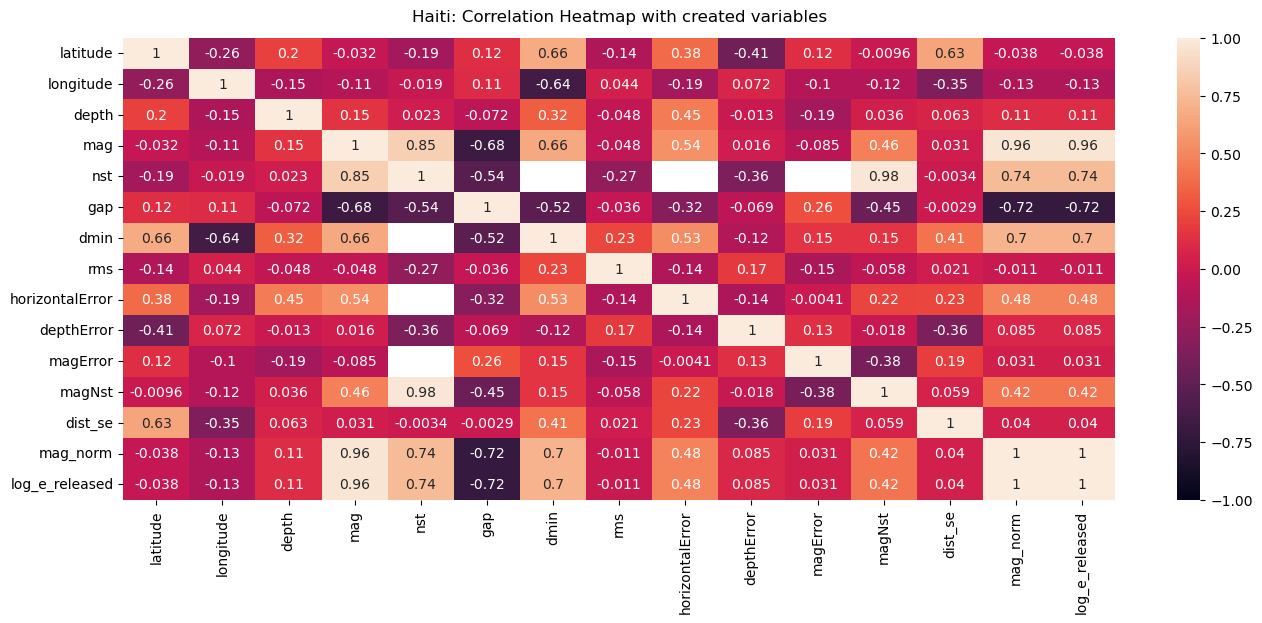

In [9]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(mod_haiti.corr(), vmin=-1, vmax=1, annot=True);

heatmap.set_title('Haiti: Correlation Heatmap with created variables', fontdict={'fontsize':12}, pad=12);


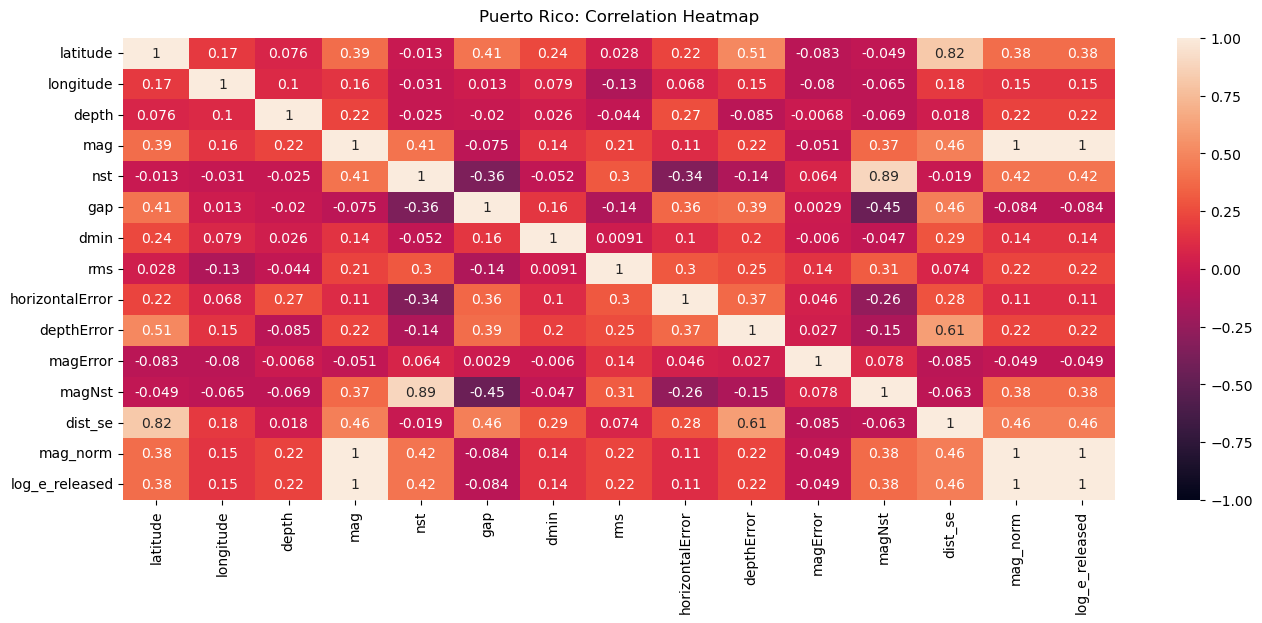

In [10]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(mod_pr.corr(), vmin=-1, vmax=1, annot=True);

heatmap.set_title('Puerto Rico: Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

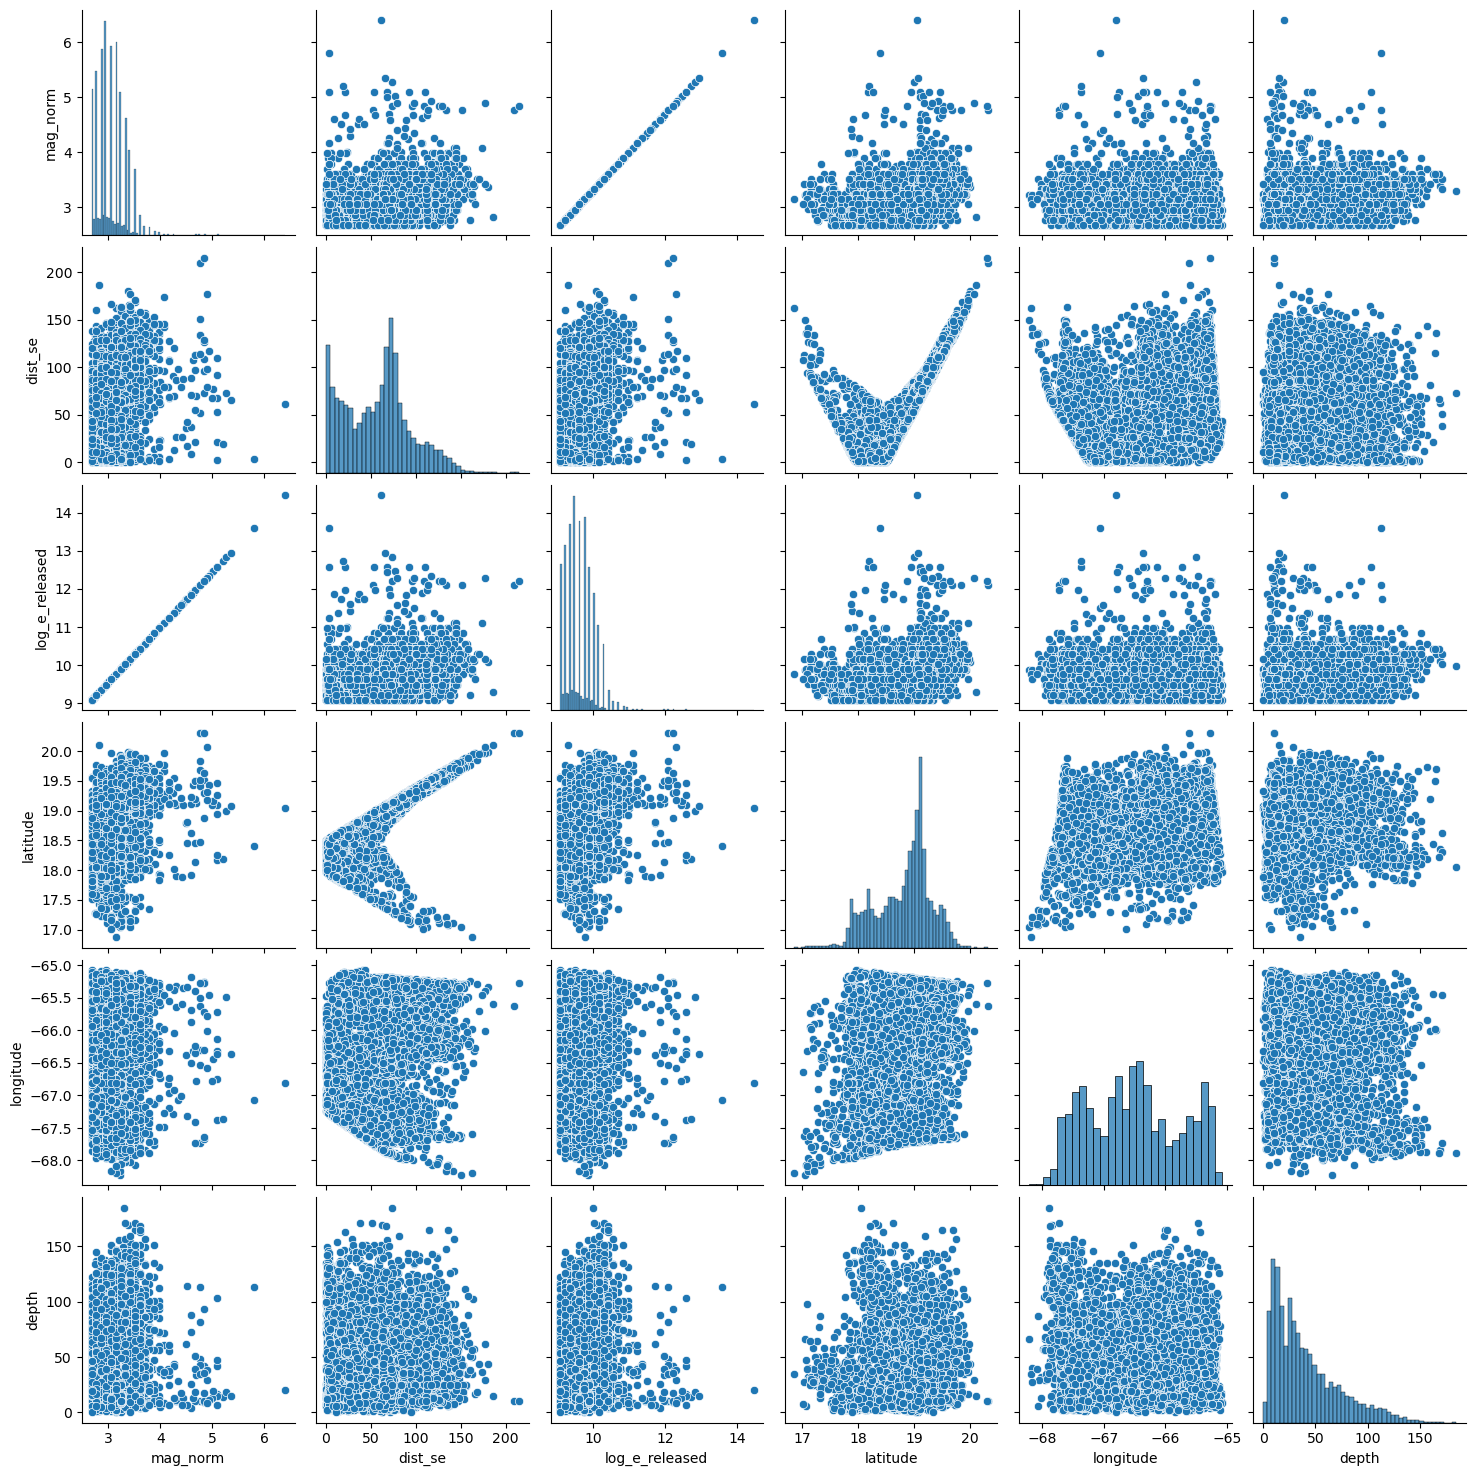

In [80]:
# right skewed mag and energy released 
m_d = mod_pr[['mag_norm','dist_se', 'log_e_released','latitude','longitude','depth']]
sns.pairplot(m_d, kind='scatter')
plt.show()

In [12]:
mod_pr.columns

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'city,region', 'dist_se', 'city',
       'country', 'mag_norm', 'log_e_released'],
      dtype='object')

In [69]:
# double checking for nans 
mod_pr[['latitude','longitude','log_e_released','mag_norm', 'dist_se','depth']].isna().sum()

latitude          0
longitude         0
log_e_released    0
mag_norm          0
dist_se           0
depth             0
dtype: int64

## Baselines

In [70]:
# splitting 
X_vars = mod_pr[['latitude','longitude','mag_norm','dist_se', 'log_e_released']]
target = mod_pr['depth']

train_size = int(mod_pr.shape[0]*0.8)

X_train =X_vars.iloc[:train_size,:]
y_train = target.iloc[:train_size]
X_test =X_vars.iloc[train_size:,:]
y_test = target.iloc[train_size:]

In [76]:
# simple random forest
r_f = RandomForestRegressor(n_estimators=100).fit(X_train,y_train)

# baseline rf performance
print('r_f r-sq',r_f.score(X_train,y_train))
print('r_f test r-sq',r_f.score(X_test,y_test))

r_f r-sq 0.911462584695526
r_f test r-sq 0.24274044085102997


In [75]:
# baseline lgbm
lgbm_base = LGBMRegressor(n_estimators=100).fit(X_train,y_train)
# lgbm performance
print('lgbm r-sq',lgbm_base.score(X_train,y_train))
print('lgbm test r-sq',lgbm_base.score(X_test,y_test))

lgbm r-sq 0.5767867857179754
lgbm test r-sq 0.2944055238714177


In [74]:
# baseline xgboost
xgb_base = XGBRegressor(n_estimators=100).fit(X_train,y_train)
# xgboost performance 
print('xgb r-sq',xgb_base.score(X_train,y_train))
print('xgb test r-sq',xgb_base.score(X_test,y_test))

xgb r-sq 0.7485223670685939
xgb test r-sq 0.2130345768351013


### Models (without scaling)

In [47]:
# random forest regressor 
# predicting EQ depth from mag_norm

X_vars = mod_pr[['latitude','longitude','mag_norm','dist_se', 'log_e_released']]
target = mod_pr['depth']

train_size = int(mod_pr.shape[0]*0.8)

X_train =X_vars.iloc[:train_size,:]
y_train = target.iloc[:train_size]
X_test =X_vars.iloc[train_size:,:]
y_test = target.iloc[train_size:]

#X_train, X_test, y_train, y_test = train_test_split(X_vars, target, test_size=0.40)

rf_params = {
    'n_estimators': [200,300,350,400,500],
    'max_features': ['auto','sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(5, 100, num = 5)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }
rf = RandomForestRegressor() 
rf_rscv = RandomizedSearchCV(estimator=rf, param_distributions=rf_params,
n_iter=20, cv=3, verbose=False, random_state=42)

In [48]:
# rf_rscv fitting 
rf_rscv.fit(X_train, y_train)

/Users/cassak1/opt/anaconda3/envs/mlclimate/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/cassak1/opt/anaconda3/envs/mlclimate/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/cassak1/opt/anaconda3/envs/mlclimate/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [5, 28, 52, 76, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 350, 400,
                                                         500]},
                   random_state=42, verbose=False)

In [49]:
# PR: randomized search cv performance
print(f'best params:{rf_rscv.best_params_}')
print(f'r_sq training:{rf_rscv.score(X_train, y_train)}')
print(f'r_sq test:{rf_rscv.score(X_test, y_test)}')

best params:{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 100}
r_sq training:0.65388358810698
r_sq test:0.2930353751478397


In [50]:
#
RF = RandomForestRegressor(n_estimators=rf_rscv.best_params_['n_estimators'],
max_depth=rf_rscv.best_params_['max_depth'], max_features=rf_rscv.best_params_['max_features'], min_samples_split=rf_rscv.best_params_['min_samples_split'],
min_samples_leaf=rf_rscv.best_params_['min_samples_leaf'], random_state=42)

RF.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, max_features='log2', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=400, random_state=42)

Text(0.5, 1.0, 'Random Forest Feature Importance')

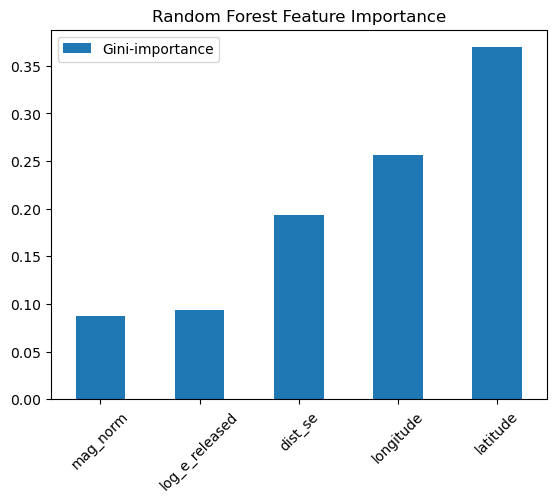

In [51]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_vars.columns, RF.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45).set_title('Random Forest Feature Importance')

In [52]:
# predictions
rf_y_train_pred = RF.predict(X_train)
rf_y_test_pred = RF.predict(X_test)

print('rf r-sq',RF.score(X_train,y_train))
print('rf test r-sq',RF.score(X_test,y_test))

rf r-sq 0.6555914110097001
rf test r-sq 0.29239438358696634


### Light GBM

In [53]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
import time

In [54]:
# train test split sequentially since data is sequential (time recorded)
# 80% train, 20% split
train_size = int(mod_pr.shape[0]*0.8)

X_train =X_vars.iloc[:train_size,:]
y_train = target.iloc[:train_size]
X_test =X_vars.iloc[train_size:,:]
y_test = target.iloc[train_size:]


In [55]:
print('total feature training features: ', len(X_train))
print('total feature testing features: ', len(X_test))
print('total target training features: ', len(y_train))
print('total target testing features: ', len(y_test))

total feature training features:  7346
total feature testing features:  1837
total target training features:  7346
total target testing features:  1837


In [56]:
start = time.time()
lgb_params = {'max_depth': [-1,1,2],
              'n_estimators': [100, 150, 200,300,400],
              'learning_rate': [0.01, 0.1, 1]}
        
lgb_rscv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(objective = 'regression',seed=27),
                              param_distributions = lgb_params, cv=10,random_state=42, n_iter=10)

lgb_rscv.fit(X_train, y_train)
finish = time.time()

print('Random Search fitting time: ', finish-start)
print("Best paramters and score:", lgb_rscv.best_params_,lgb_rscv.best_score_)

Random Search fitting time:  12.185903787612915
Best paramters and score: {'n_estimators': 400, 'max_depth': -1, 'learning_rate': 0.01} 0.3571578889230864


In [57]:
# retrieve best parameters
LGBM = lgb.LGBMRegressor(learning_rate = lgb_rscv.best_params_['learning_rate'],
                     max_depth = lgb_rscv.best_params_['max_depth'], n_estimators = lgb_rscv.best_params_['n_estimators'],
                     objective = 'regression',seed=27)

LGBM.fit(X_train,y_train)

LGBMRegressor(learning_rate=0.01, n_estimators=400, objective='regression',
              seed=27)

Text(0.5, 1.0, 'LightGBM Feature Importance')

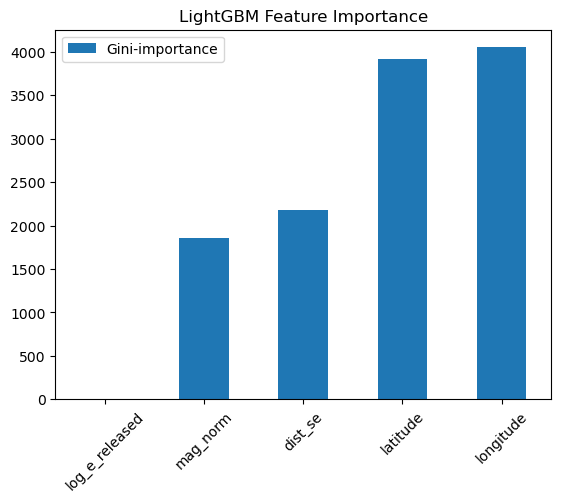

In [58]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_vars.columns, LGBM.feature_importances_):
    feats[feature] = importance #add the name/value pair 

lgb_importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
lgb_importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45).set_title('LightGBM Feature Importance')

In [59]:
# predictions
lgb_y_train_pred = LGBM.predict(X_train)
lgb_y_test_pred = LGBM.predict(X_test)

print('lgb train r-sq',LGBM.score(X_train,y_train))
print('lgb test r-sq',LGBM.score(X_test,y_test))

lgb train r-sq 0.5010148069032707
lgb test r-sq 0.29492544666579346


## XGBoost

In [67]:
from xgboost.sklearn import XGBRegressor

In [68]:
start = time.time()
xgb_params = {'max_depth': [2,10,32],
'n_estimators': [100,200,300,400],
'learning_rate': [0.01, 0.1, 1]}

xgb_rscv = RandomizedSearchCV(estimator=XGBRegressor(objective = 'reg:squarederror',seed=27), 
                                  param_distributions = xgb_params, cv=10,random_state=42, n_iter=10) 
    #scoring='r2' (may not be used)
xgb_rscv.fit(X_train,y_train)
finish = time.time()

print('Random Search fitting time: ', finish-start)
print("Best paramters and score:", xgb_rscv.best_params_,xgb_rscv.best_score_)

Random Search fitting time:  201.24137711524963
Best paramters and score: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.1} 0.32569558051588


In [65]:
# get best params and build with all dev data
xgb = XGBRegressor(learning_rate = xgb_rscv.best_params_['learning_rate'],
max_depth = xgb_rscv.best_params_['max_depth'], n_estimators = xgb_rscv.best_params_['n_estimators'],
objective = 'reg:squarederror',scoring='r2',seed=27)

xgb.fit(X_train,y_train)

[16:43:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scoring" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=32, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=27, ...)

In [66]:
# get predictions 
xgb_y_train_pred = xgb.predict(X_train)
xgb_y_test_pred = xgb.predict(X_test)

print('xgb r2',xgb.score(X_train,y_train))
print('xgb test r2',xgb.score(X_test,y_test))

xgb r2 0.9601295968605792
xgb test r2 0.20734821693408567


Text(0.5, 1.0, 'XGBoost Feature Importance')

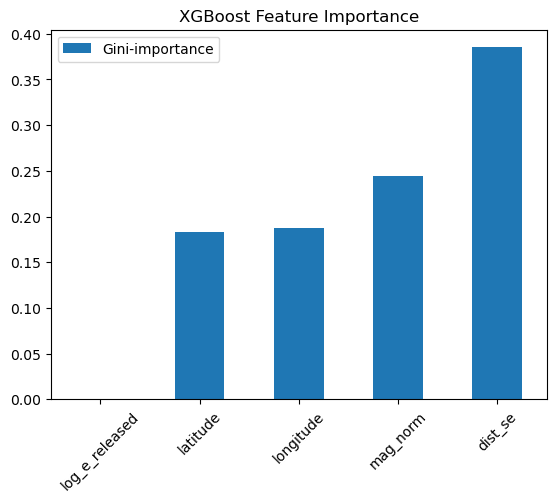

In [77]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_vars.columns, xgb.feature_importances_):
    feats[feature] = importance #add the name/value pair 

xgb_importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
xgb_importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45).set_title('XGBoost Feature Importance')

## With scaling/ log transformations - to address skewed data

In [115]:
# features and target
df = mod_pr[['latitude','longitude','mag_norm','depth','dist_se', 'log_e_released']]

 #remove rows that are not finite
 
X = df[['latitude','longitude','mag_norm','dist_se', 'log_e_released']]
#X = np.nan_to_num(X)
#X = X[np.isfinite(X).all(1)]

y = df[['depth']]

# log transform skewed predictors
X.mag_norm = np.log(X.mag_norm)
X.dist_se = np.log(X.dist_se)
#X.log_e_released = np.log(X.log_e_released)

# log transform target 
y.depth = np.log(y.depth)

X_train =X.iloc[:train_size,:]
y_train = y.iloc[:train_size]
X_test =X.iloc[train_size:,:]
y_test = y.iloc[train_size:]

/var/folders/h4/myxt4p6x1d718x1wkt4pl3kh0000gq/T/ipykernel_54810/1740769775.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.mag_norm = np.log(X.mag_norm)
/Users/cassak1/opt/anaconda3/envs/mlclimate/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/h4/myxt4p6x1d718x1wkt4pl3kh0000gq/T/ipykernel_54810/1740769775.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dist_se = np.l

In [116]:
# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ValueError: Input X contains infinity or a value too large for dtype('float64').

In [117]:
minmax = MinMaxScaler()
y_train = pd.Series(minmax.fit_transform(pd.DataFrame(y_train)).reshape(1,-1)[0])
y_test = pd.Series(minmax.transform(pd.DataFrame(y_test)).reshape(1,-1)[0])

ValueError: Input X contains infinity or a value too large for dtype('float64').